### Installing required Packages

In [ ]:
! pip install tensorflow==2.1.0
! pip install -U segmentation-models
!pip install import_ipynb
from IPython.display import clear_output
clear_output()

### Importing required modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import segmentation_models as sm
import tensorflow.keras,os
tensorflow.keras.backend.set_image_data_format('channels_last')
import import_ipynb, urllib.request
! cp -v "/content/drive/My Drive/IID_Files1/Utility_Functions.ipynb" "/content" 
from Utility_Functions import *
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Function-1 Definition

In [2]:
def Function_1(path_i,Mean_MIoU=None,cf_matrix=None,Accuracy=None,Model=None,load=True,Read_from_File=True,plot=True,path_l=0,plot_limit=2):

    '''
    ----------------------------------------------------------------------------
    The Function contains the entire Deep Learning pipeline 
    Function predicts the output for given raw input

    1. Reading Image data files from a specified directory.
    2. Preprocessing Images by Resizing and Normalization.
    3. Preparation of Data to make it suitable for prediction.
    4. Deep learning Model Prediction for prepared input.
    5. Finally Plotting of the predicted image segmentation.  
    ----------------------------------------------------------------------------
        Parameters
        ----------
        path_i <string>                 : Absolute Path of images Data files
        Read_from_File <Boolean>        : Indicator to specify input format
        plot_limit <Int>                : Plot limit of segmentaion output
        Model <Int>                     : Model Choice for prediction
        Other Parameters	            : **kwargs other properties
    
        returns 
        --------
        Output Arguments             : Output values
    ----------------------------------------------------------------------------

    '''

    # Image resolution and classes
    height, width, n_classes = 224, 480, 7
    
    # Load selected Deep Learning model
    if load: Model = Select_Model()
    
    # Function to predict Batch wise to avoid run out of memory
    def Predict_Segment(i,data,lab,pb_size,Mean_MIoU,cf_matrix,Accuracy):
        
        '''  Function to perform prediction for a given subset of Data at a time  '''
        
        # Get index offset for data 
        s, e = i, min(i+pb_size,len(data))        
        
        if Read_from_File == True: # Image Data preparation
            test_images = image_prepare(path_i,data[s:e],Model)
            y_true = label_prepare(path_l,lab[s:e],Model) if isinstance(path_l, str) else [0]   #decompress sparce
        else:
            test_images = image_prepare_j(data[s:e],Model)
            y_true = label_prepare_j(lab[s:e],Model) if isinstance(path_l, list) else [0]
        
        # Model Prediction 
        y_pred = Model.predict(test_images)  
        
        # Get Actual Labels from Predicted probabilities and compute some metrics if label is avaliable
        pred_Out,pred_labels,true_Out,true_labels,cf_matrix,Accuracy = prob_to_label(cf_matrix,Accuracy,y_pred,y_true)
        if isinstance(path_l, str) or isinstance(path_l, list):
            Mean_MIoU = Intersect_over_union(np.array(true_Out),np.array(pred_Out),Mean_MIoU)

        if plot: # ploting Few Segmentation Samples from prediction 
          if ((i==0) or ((pb_size==1) and i<plot_limit)):
            if (i==0):print("\nFew Segmentation Samples:>>>\n")
            plot_segmentation(test_images,pred_labels,true_labels,plot_limit) 
        
        return pred_Out, true_Out,pred_labels,true_labels,cf_matrix,Mean_MIoU,Accuracy
    
    if Read_from_File: # Reading all Data files from specified Path 
        data = sorted(os.listdir(path_i))
        lab = sorted(os.listdir(path_l)) if (isinstance(path_l, str) or isinstance(path_l, list)) else 0
    else:
        data, lab = path_i,path_l if (isinstance(path_l, str) or isinstance(path_l, list)) else 0
    
    # Computing subset size for samples for prediction 
    pb_size=1 if (len(data)<plot_limit) or Model.name=="SEGNET" else plot_limit
    Pred_org,y_true_org,pred_labels_org,true_labels_org = [],[],[],[]

    # Invoke Predict_Segment() for prediction for many subset of Samples
    for i in range(0,len(data),pb_size):
        dat = Predict_Segment(i,data,lab,pb_size,Mean_MIoU,cf_matrix,Accuracy)
        Pred_org.extend(dat[0]),y_true_org.extend(dat[1])
        pred_labels_org.extend(dat[2]),true_labels_org.extend(dat[3])
        cf_matrix = dat[4]
    
    return np.array(pred_labels_org,dtype=np.uint8),np.array(true_labels_org,dtype=np.uint8),dat[4],dat[5],dat[6]

# Function-2 Definition

In [3]:
def Function_2(path_img,path_lab,Mean_MIoU=None,cf_matrix=None,Accuracy=None,Model=None,plot=True,Read_from_File=True,load=True,cr=True,plot_limit=2):
    
    '''
    ---------------------------------------------------------------------------------------
    The Function implements the entire Deep Learning pipeline where it accepts 
    Images and Labels to predict output and calculates segmentation  metrics

    1. Accept Images and Labels data as input from the directory
    2. perform Preprocessing and Data Preparation
    3. Model Prediction for prepared Data as input
    4. Performance Calculation using multiple metics
    5. Finally printing and Plotting of the prediction results
    ---------------------------------------------------------------------------------------
        Parameters
        ----------
        path_img, path_lab <string>                    : Absolute Path of Images and labels.
        Read_from_File <Boolean>                       : Indicator to specify input format
        Mean_MIoU, cf_matrix, Accuracy <metrics>       : Variables to store prediction Scores
        plot_limit <Int>                               : Plot limit of segmentaion output
        Model <Int>                                    : Model Choice for prediction
        Other Parameters	                           : **kwargs other properties

        returns 
        --------
        Mean_MIoU, cf_matrix, Accuracy                 : resulting Performance Metrics
    ----------------------------------------------------------------------------------------

    '''

    # perform prediction by calling function1 
    pred_labels_org,true_labels_org,cf_matrix,Mean_MIoU,Accuracy = Function_1(path_img,Mean_MIoU,cf_matrix,Accuracy,Model,load,Read_from_File,plot,path_lab,plot_limit)
    
    # printing prediction result
    if plot: Print_result(Mean_MIoU,cf_matrix,Accuracy,true_labels_org,pred_labels_org,cr)
    
    return Mean_MIoU, cf_matrix, Accuracy

# Function-1 Invocation for Prediction

Total number of samples : 10

    1.Restnet_50+U-Net    2.Unet    3.DeeplabV3    4.Pspnet    5.Segnet >> Enter a number to Choose a Model:
>>> 1

Few Segmentation Samples:>>>



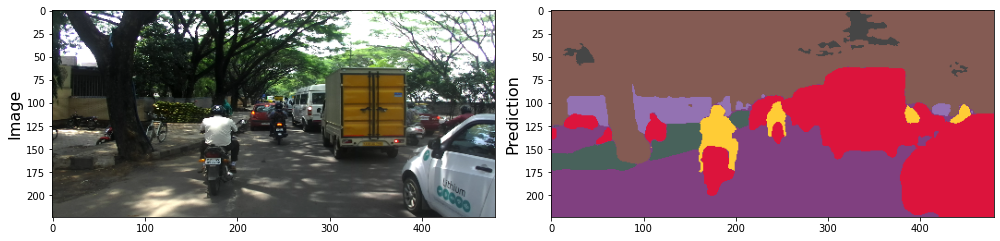

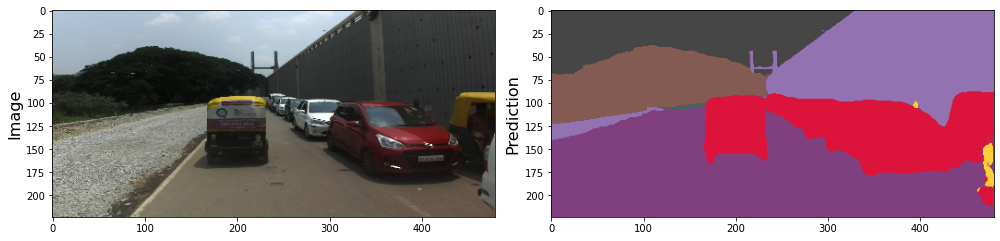

In [4]:
# function_1 call
if __name__ == '__main__':
    
    # Data files path
    Image_path = "/content/drive/My Drive/Test Source/Multiple_Files_Function_1/Image/"
    print("Total number of samples : {0}\n".format(len(os.listdir(Image_path))))

    # invoke function_1
    res = Function_1(Image_path, plot_limit=2, Read_from_File=True)

# Function-2 Invocation for Prediction

Total number of samples : 20

    1.Restnet_50+U-Net    2.Unet    3.DeeplabV3    4.Pspnet    5.Segnet >> Enter a number to Choose a Model:
>>> 2

Few Segmentation Samples:>>>



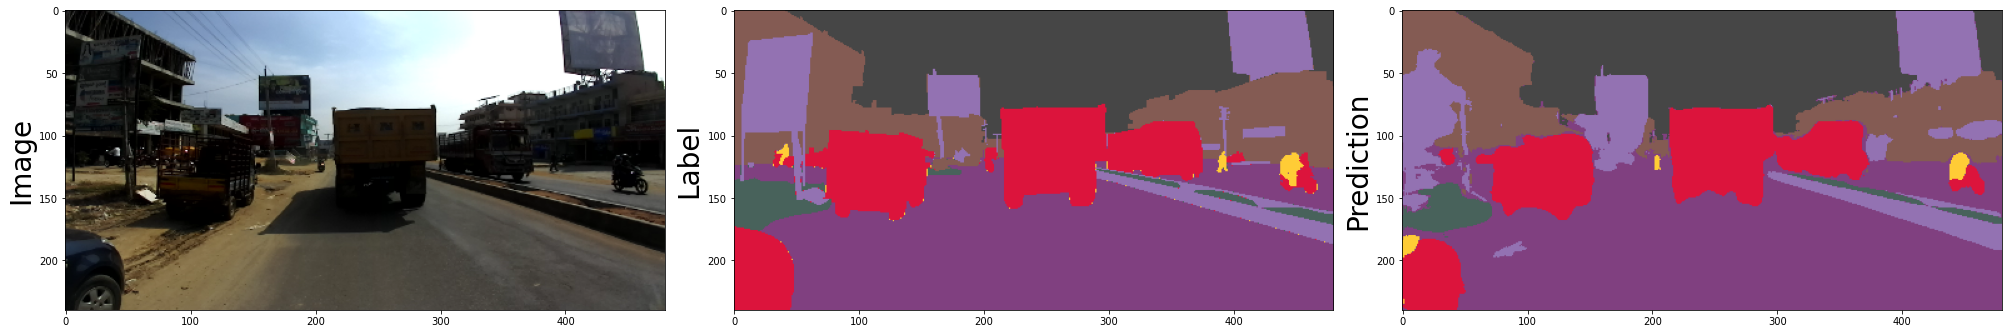

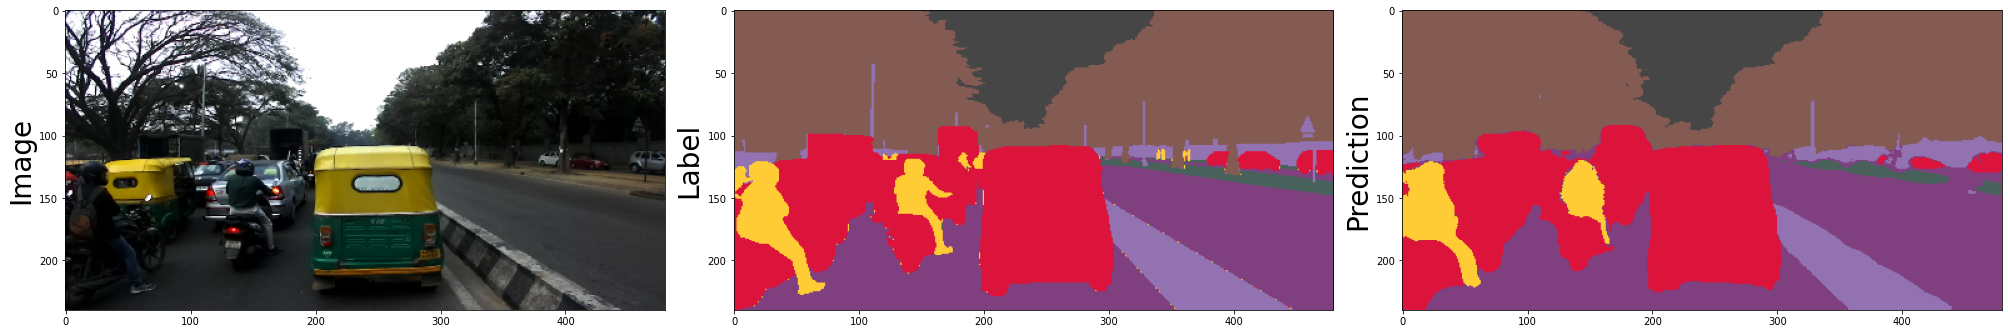


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.6883

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.9301

-----------------------
|  Confusion Matrix   |
-----------------------


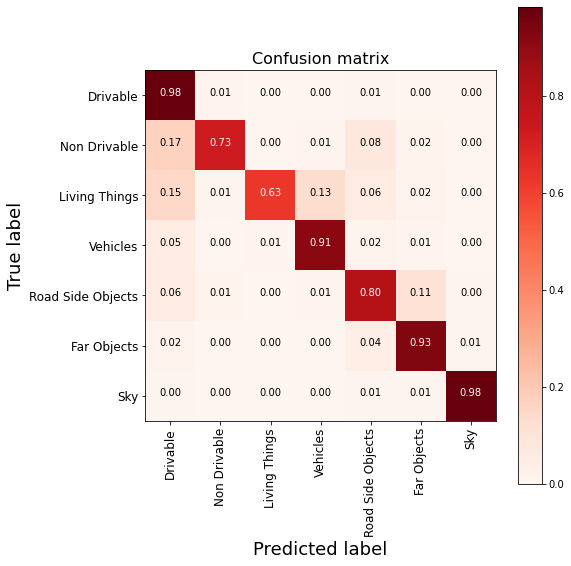

-------------------------
| Classifiction Report  |
-------------------------

               precision    recall  f1-score   support

           0       0.93      0.98      0.96    753358
           1       0.77      0.73      0.75     52984
           2       0.84      0.63      0.72     25596
           3       0.95      0.91      0.93    230441
           4       0.85      0.80      0.82    279008
           5       0.93      0.93      0.93    564644
           6       0.99      0.98      0.98    397969

    accuracy                           0.93   2304000
   macro avg       0.89      0.85      0.87   2304000
weighted avg       0.93      0.93      0.93   2304000

{'Drivable': 0, 'Non Drivable': 1, 'Living Things': 2, 'Vehicles': 3, 'Road Side Objects': 4, 'Far Objects': 5, 'Sky': 6}


In [5]:
# function_2 call
if __name__ == '__main__':

    # Data and label files path
    Image_path = "/content/drive/My Drive/Test Source/Multiple_Files_Function_2/Image/"
    Label_path = "/content/drive/My Drive/Test Source/Multiple_Files_Function_2/Lab/"
    print("Total number of samples : {0}\n".format(len(os.listdir(Image_path))))

    # invoke function_2
    Mean_MIoU, Accuracy, cf_matrix = [], [], np.zeros((7,7))
    res = Function_2(Image_path, Label_path, Mean_MIoU, cf_matrix, Accuracy, plot_limit=2, Read_from_File=True)

# Prediction by Image URL 

Enter the Image url here:
>>> https://da4dkroembtou.cloudfront.net/wp-content/uploads/2018/10/BMW_X5_PHEV_2015-56.jpg
1.Unet    2.DeeplabV3    3.Pspnet    4.Segnet >> Enter a number to Choose a Model:
>>> 1

Few Segmentation Samples:>>>



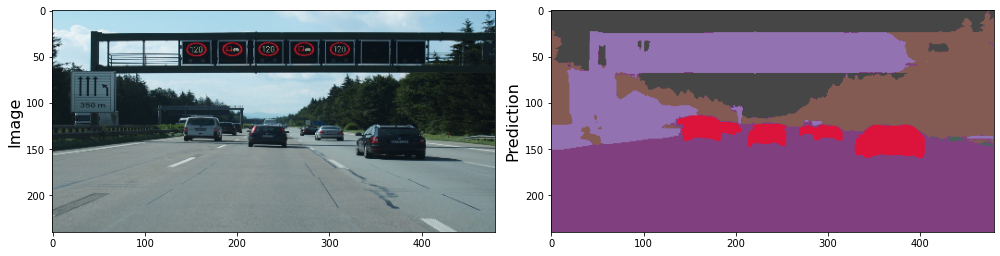

In [ ]:
if __name__ == '__main__':
    
    # Create a simple directory
    Image_path = "/content/imgs/"
    if not os.path.exists(Image_path):os.makedirs(Image_path)

    # retrive a network object denoted by a URL to a local file
    img_url=input("Enter the Image url here:\n>>> ")
    urllib.request.urlretrieve(img_url, "/content/imgs/image.jpg")

    # invoke function for Prediction
    res = Function_1(Image_path, plot_limit=1, Read_from_File=True)

# Runtime Prediction for a video

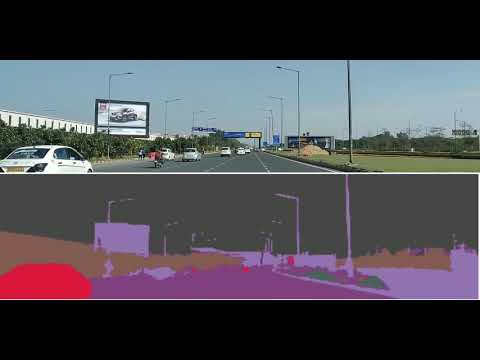

In [ ]:
if __name__ == '__main__':
    from IPython.display import YouTubeVideo
    YouTubeVideo('OMSnas3GwaI', width=896, height=448)